<div dir="rtl">
    <font size="4"><b>پروژه پنجم (فاز دوم) – بررسی برخی از مسائل شبکه های عصبی به کمک Tensorflow</b><br></font>
    <font size="3">هدف پروژه: در این پروژه قصد داریم با کتابخانه TensorFlow و با استفاده از رابط سطح بالای Keras برخی از مسائل مربوط به شبکه های عصبی را بررسی نماییم. در این مسئله قصد داریم به کمک شبکه عصبی نژاد هر فرد را براساس تصویر چهره او تشخیص دهیم.<br>
    مجموعه داده: مجموعه داده UTKFace شامل بیش از 20000 تصویر چهره همراه با سن،جنسیت و نژاد هر فرد است.</font>
</div>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp "/content/drive/MyDrive/UTKFace.tar.gz" .

In [ ]:
!tar xvzf UTKFace.tar.gz

In [5]:
from tensorflow.keras import *
from tensorflow.keras.utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import os
%matplotlib inline

<div dir="rtl">
    <font size="4"><b>فاز اول: بررسی و پیش پردازه داده</b><br></font>
    <font size="3"></font>
</div>

<div dir="rtl">
    <font size="3">خواندن داده ها به کمک keras و چاپ تعداد داده های خوانده شده و تعداد کلاس های موجود:</font>
</div>

In [7]:
img_path = list()
races = list()
path = "/content/UTKFace"
for img in os.listdir(path):
  temp = img.split('.')
  if len(temp[0].split('_')) == 4:
    img_path.append(os.path.join(path, img))
    age, gender, race, date = temp[0].split('_')
    races.append(int(race))
  else:
    continue

class_names = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Others"}
races = [str(to_categorical(i, len(class_names))) for i in races]

df = pd.DataFrame({
    'image': img_path,
    'race': races
})

<div dir="rtl">
    <font size="3">به این دلیل از one hot encoding استفاده میکنیم زیرا اگر از روشی مانند label encoding استفاده کنیم ممکن است این برداشت اشتباه صورت بگیرد که بین این برچسب ها یک رابطه ترتیبی وجود دارد.<br>
    مجموعه داده را به دو بخش test و train تقسیم میکنیم و داده ها را نیز نرمال میکنیم (برای اینکار هر پیکسل را بر 255 تقسیم میکنیم.)</font>
</div>

In [8]:
data_generator = preprocessing.image.ImageDataGenerator(
    rescale = 1/255.0,
    validation_split = 0.3
)

<div dir="rtl">
    <font size="3">تصاویر را grayscale کرده و به مقیاس 100 در 100 تغییر میدهیم.</font>
</div>

In [9]:
train_data = data_generator.flow_from_dataframe(
    dataframe = df,
    x_col = 'image',
    y_col = 'race',
    target_size = (100, 100),
    color_mode = "grayscale",
    batch_size = 32,
    class_mode = "categorical",
    subset = "training"
)

test_data = data_generator.flow_from_dataframe(
    dataframe = df,
    x_col = 'image',
    y_col = 'race',
    target_size = (100, 100),
    color_mode = "grayscale",
    batch_size = 32,
    class_mode = "categorical",
    subset = "validation"
)

Found 16594 validated image filenames belonging to 5 classes.
Found 7111 validated image filenames belonging to 5 classes.


<div dir="rtl">
    <font size="3">تعداد تصاویر هر کلاس را محاسبه میکنیم و برای آن نمودار میله ای رسم میکنیم.</font>
</div>

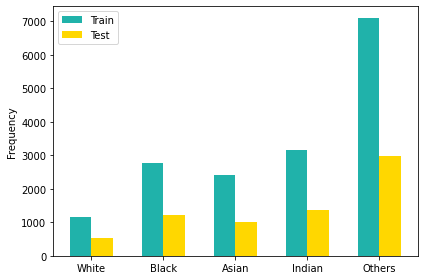

In [10]:
class_name = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Others"}

num_of_clases_train = [0]*5
for label in train_data.labels:
  num_of_clases_train[label] += 1

num_of_clases_test = [0]*5
for label in test_data.labels:
  num_of_clases_test[label] += 1

x = np.arange(5)
fig, ax = plt.subplots()
ax.bar(x - 0.15, num_of_clases_train, 0.3, label='Train', color='lightseagreen')
ax.bar(x + 0.15, num_of_clases_test, 0.3, label='Test', color='gold')
ax.set_ylabel('Frequency')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(class_name.values())
ax.legend()
fig.tight_layout()
plt.show()

<div dir="rtl">
    <font size="3">از هر کلاس موجود یک تصاویر همراه با نام کلاس آن نشان میدهیم.</font>
</div>

<Figure size 432x288 with 0 Axes>

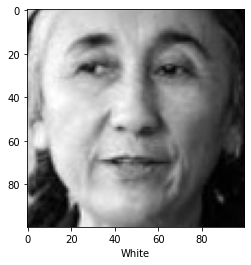

<Figure size 432x288 with 0 Axes>

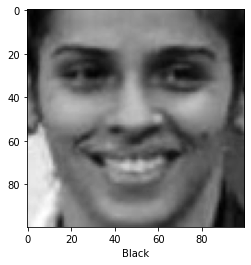

<Figure size 432x288 with 0 Axes>

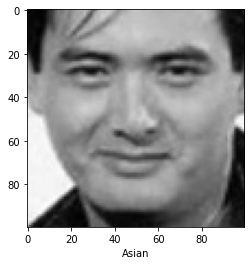

<Figure size 432x288 with 0 Axes>

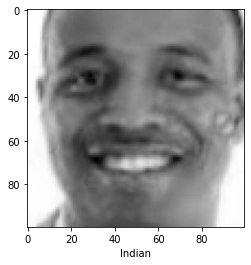

<Figure size 432x288 with 0 Axes>

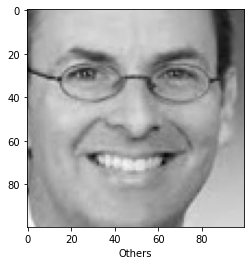

In [9]:
i = 0
for images, labels in train_data:
  if i >= 5:
    break
  for image, label in zip(images, labels):
    if label.argmax() == i:
      plt.figure()
      fig, ax = plt.subplots()
      plt.xlabel(class_name[i])
      plt.imshow(image.reshape((100, 100)), cmap='gray')
      i += 1

<div dir="rtl">
    <font size="4"><b>فاز دوم: طراحی شبکه عصبی</b><br></font>
    <font size="3"></font>
</div>

In [32]:
input = layers.Input(shape=(100, 100, 1))
x = layers.Flatten()(input)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
output = layers.Dense(5, activation='softmax')(x)
model = models.Model(inputs=input, outputs=output)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

<div dir="rtl">
    <font size="3">تعداد پارامترهای هر لایه: تعداد پارامترهای هر لایه برابر است با تعداد ورودی هر لایه*تعداد نورونهای لایه + بایاس. برای مثال در dense_21 تعداد پارامترها برابر است با 10000*1024 + 1024</font>
</div>

In [33]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 2565      
Total params: 10,768,389
Trainable params: 10,768,389
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
519/519 [==============================] - 54s 104ms/step - loss: 1.2819 - accuracy: 0.5016 - val_loss: 1.2271 - val_accuracy: 0.5489
Epoch 2/10
519/519 [==============================] - 54s 104ms/step - loss: 1.1103 - accuracy: 0.5789 - val_loss: 1.1164 - val_accuracy: 0.5989
Epoch 3/10
519/519 [==============================] - 54s 103ms/step - loss: 1.0313 - accuracy: 0.6172 - val_loss: 0.9411 - val_accuracy: 0.6628
Epoch 4/10
519/519 [==============================] - 54s 104ms/step - loss: 0.9766 - accuracy: 0.6439 - val_loss: 0.9521 - val_accuracy: 0.6576
Epoch 5/10
519/519 [==============================] - 55s 105ms/step - loss: 0.9320 - accuracy: 0.6599 - val_loss: 0.8866 - val_accuracy: 0.6924
Epoch 6/10
519/519 [==============================] - 54s 103ms/step - loss: 0.9169 - accuracy: 0.6681 - val_loss: 1.0692 - val_accuracy: 0.5771
Epoch 7/10
519/519 [==============================] - 53s 103ms/step - loss: 0.8855 - accuracy: 0.6793 - val_loss: 1.2229 - val_ac

In [13]:
def report(model, data, class_name, str):
  y_true = list()
  batches = len(data.classes) // data.batch_size
  if batches < len(data.classes) / data.batch_size:
    batches += 1
  for i in range(batches):
    x, y = data.next()
    for label in y:
      y_true.append(np.argmax(label))
  y_true = np.array(y_true)
  y_pred = np.argmax(model.predict(data), axis=1)
  print(str + ':')
  print(classification_report(y_true, y_pred, target_names=class_name.values()))

In [36]:
report(model, train_data, class_name, "train")

train:
              precision    recall  f1-score   support

       White       0.05      0.01      0.01      1166
       Black       0.17      0.39      0.23      2767
       Asian       0.13      0.06      0.08      2412
      Indian       0.19      0.22      0.20      3155
      Others       0.42      0.32      0.36      7094

    accuracy                           0.25     16594
   macro avg       0.19      0.20      0.18     16594
weighted avg       0.27      0.25      0.24     16594



In [37]:
report(model, test_data, class_name, "test")

test:
              precision    recall  f1-score   support

       White       0.46      0.05      0.09       525
       Black       0.38      0.87      0.53      1209
       Asian       0.85      0.36      0.51      1023
      Indian       0.69      0.81      0.75      1370
      Others       0.81      0.60      0.69      2984

    accuracy                           0.61      7111
   macro avg       0.64      0.54      0.51      7111
weighted avg       0.69      0.61      0.60      7111



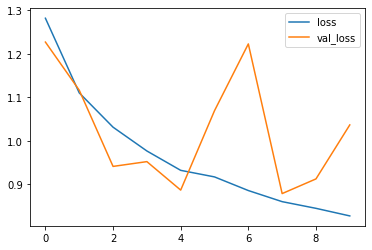

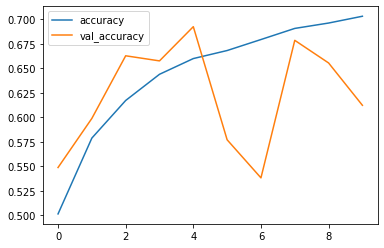

In [38]:
model_history = pd.DataFrame(history.history)
model_history[['loss', 'val_loss']].plot()
model_history[['accuracy', 'val_accuracy']].plot()

<div dir="rtl">
    <font size="4"><b>فاز سوم: طبقه بندی داده ها</b><br></font>
</div>

<div dir="rtl">
    <font size="3">قسمت اول) تاثیر optimizer <br>
    •استفاده از momentum مانند این است که در مینیمم های محلی که آپدیت شدن وزنها مقادیر ناچیزی دارد، به وزنها ضربه زده میشود تا از مینیمم محلی خارج شوند. در واقع استفاده از momentum مناسب باعث میشود که در مینیمم های محلی گیر نکنیم و روند آموزش را سریعتر میکند.<br>
    •آموزش مدل با momentum 0.5: نتیجه کمی بهتر میشود.</font>
</div>

In [39]:
input = layers.Input(shape=(100, 100, 1))
x = layers.Flatten()(input)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
output = layers.Dense(5, activation='softmax')(x)
model = models.Model(inputs=input, outputs=output)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01,momentum=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
519/519 [==============================] - 58s 112ms/step - loss: 1.2419 - accuracy: 0.5194 - val_loss: 1.1192 - val_accuracy: 0.6123
Epoch 2/10
519/519 [==============================] - 58s 111ms/step - loss: 1.0505 - accuracy: 0.6118 - val_loss: 0.9361 - val_accuracy: 0.6597
Epoch 3/10
519/519 [==============================] - 57s 111ms/step - loss: 0.9712 - accuracy: 0.6452 - val_loss: 0.9000 - val_accuracy: 0.6799
Epoch 4/10
519/519 [==============================] - 58s 111ms/step - loss: 0.9291 - accuracy: 0.6652 - val_loss: 0.9561 - val_accuracy: 0.6608
Epoch 5/10
519/519 [==============================] - 58s 112ms/step - loss: 0.8985 - accuracy: 0.6783 - val_loss: 0.9506 - val_accuracy: 0.6562
Epoch 6/10
519/519 [==============================] - 58s 112ms/step - loss: 0.8676 - accuracy: 0.6865 - val_loss: 0.8871 - val_accuracy: 0.6834
Epoch 7/10
519/519 [==============================] - 59s 114ms/step - loss: 0.8511 - accuracy: 0.6918 - val_loss: 1.0179 - val_ac

In [40]:
report(model, train_data, class_name, "train")
report(model, test_data, class_name, "test")

train:
              precision    recall  f1-score   support

       White       0.09      0.03      0.05      1165
       Black       0.17      0.09      0.12      2763
       Asian       0.15      0.16      0.15      2419
      Indian       0.18      0.15      0.17      3149
      Others       0.43      0.57      0.49      7098

    accuracy                           0.31     16594
   macro avg       0.20      0.20      0.19     16594
weighted avg       0.27      0.31      0.29     16594

test:
              precision    recall  f1-score   support

       White       0.30      0.10      0.14       525
       Black       0.72      0.40      0.51      1209
       Asian       0.67      0.74      0.70      1023
      Indian       0.84      0.69      0.76      1370
      Others       0.66      0.89      0.76      2984

    accuracy                           0.69      7111
   macro avg       0.64      0.56      0.57      7111
weighted avg       0.68      0.69      0.66      7111



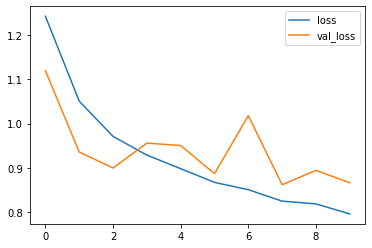

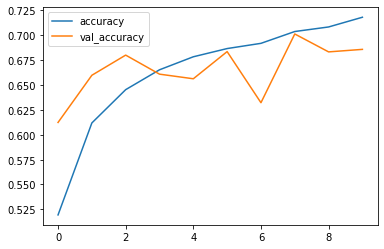

In [41]:
model_history = pd.DataFrame(history.history)
model_history[['loss', 'val_loss']].plot()
model_history[['accuracy', 'val_accuracy']].plot()

<div dir="rtl"></font>
    <font size="3">•آموزش مدل با momentum 0.9: نتیجه به میزان بسیار کمی افت میکند.<br>
    •همواره با افزایش momentum نتیجه بهبود نمیابد زیرا میتواند سبب شود که در اطراف مینیمم کل بی جهت به این طرف و آن طرف حرکت کنیم.</font>
</div>

In [42]:
input = layers.Input(shape=(100, 100, 1))
x = layers.Flatten()(input)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
output = layers.Dense(5, activation='softmax')(x)
model = models.Model(inputs=input, outputs=output)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01,momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
519/519 [==============================] - 61s 116ms/step - loss: 1.3048 - accuracy: 0.4967 - val_loss: 1.1612 - val_accuracy: 0.5520
Epoch 2/10
519/519 [==============================] - 60s 116ms/step - loss: 1.1588 - accuracy: 0.5668 - val_loss: 1.4710 - val_accuracy: 0.4240
Epoch 3/10
519/519 [==============================] - 60s 115ms/step - loss: 1.0710 - accuracy: 0.6118 - val_loss: 1.1567 - val_accuracy: 0.5483
Epoch 4/10
519/519 [==============================] - 58s 112ms/step - loss: 0.9973 - accuracy: 0.6434 - val_loss: 0.9761 - val_accuracy: 0.6507
Epoch 5/10
519/519 [==============================] - 58s 112ms/step - loss: 0.9771 - accuracy: 0.6467 - val_loss: 0.9164 - val_accuracy: 0.6728
Epoch 6/10
519/519 [==============================] - 58s 112ms/step - loss: 0.9388 - accuracy: 0.6629 - val_loss: 1.0375 - val_accuracy: 0.6228
Epoch 7/10
519/519 [==============================] - 58s 111ms/step - loss: 0.9162 - accuracy: 0.6722 - val_loss: 0.9183 - val_ac

In [48]:
report(model, train_data, class_name, "train")
report(model, test_data, class_name, "test")

train:
              precision    recall  f1-score   support

       White       0.00      0.00      0.00      1164
       Black       0.17      0.32      0.22      2753
       Asian       0.13      0.11      0.12      2419
      Indian       0.18      0.21      0.20      3163
      Others       0.42      0.33      0.37      7095

    accuracy                           0.25     16594
   macro avg       0.18      0.19      0.18     16594
weighted avg       0.26      0.25      0.25     16594



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test:
              precision    recall  f1-score   support

       White       0.00      0.00      0.00       525
       Black       0.41      0.82      0.55      1209
       Asian       0.73      0.58      0.65      1023
      Indian       0.67      0.80      0.73      1370
      Others       0.83      0.63      0.72      2984

    accuracy                           0.64      7111
   macro avg       0.53      0.57      0.53      7111
weighted avg       0.65      0.64      0.63      7111



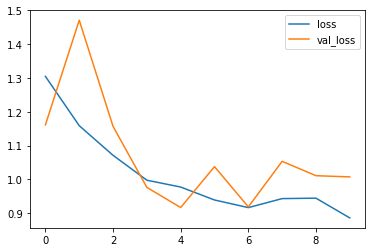

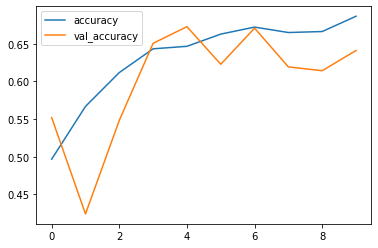

In [44]:
model_history = pd.DataFrame(history.history)
model_history[['loss', 'val_loss']].plot()
model_history[['accuracy', 'val_accuracy']].plot()

<div dir="rtl">
    <font size="3">•تمرین مدل با استفاده از Adam:</font>
</div>

In [49]:
input = layers.Input(shape=(100, 100, 1))
x = layers.Flatten()(input)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
output = layers.Dense(5, activation='softmax')(x)
model = models.Model(inputs=input, outputs=output)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
519/519 [==============================] - 64s 122ms/step - loss: 1.5178 - accuracy: 0.5145 - val_loss: 1.1241 - val_accuracy: 0.5853
Epoch 2/10
519/519 [==============================] - 63s 121ms/step - loss: 1.0574 - accuracy: 0.6114 - val_loss: 1.0879 - val_accuracy: 0.5857
Epoch 3/10
519/519 [==============================] - 63s 121ms/step - loss: 0.9762 - accuracy: 0.6485 - val_loss: 0.9290 - val_accuracy: 0.6673
Epoch 4/10
519/519 [==============================] - 63s 122ms/step - loss: 0.9259 - accuracy: 0.6734 - val_loss: 1.0777 - val_accuracy: 0.6126
Epoch 5/10
519/519 [==============================] - 63s 122ms/step - loss: 0.9066 - accuracy: 0.6745 - val_loss: 0.8990 - val_accuracy: 0.6742
Epoch 6/10
519/519 [==============================] - 63s 121ms/step - loss: 0.8901 - accuracy: 0.6818 - val_loss: 1.0382 - val_accuracy: 0.6124
Epoch 7/10
519/519 [==============================] - 63s 121ms/step - loss: 0.8705 - accuracy: 0.6896 - val_loss: 0.8748 - val_ac

In [50]:
report(model, train_data, class_name, "train")
report(model, test_data, class_name, "test")

train:
              precision    recall  f1-score   support

       White       0.08      0.03      0.04      1165
       Black       0.15      0.10      0.12      2771
       Asian       0.15      0.14      0.15      2409
      Indian       0.18      0.23      0.20      3155
      Others       0.42      0.48      0.45      7094

    accuracy                           0.29     16594
   macro avg       0.20      0.20      0.19     16594
weighted avg       0.27      0.29      0.28     16594

test:
              precision    recall  f1-score   support

       White       0.27      0.09      0.13       525
       Black       0.71      0.48      0.57      1209
       Asian       0.72      0.69      0.70      1023
      Indian       0.67      0.85      0.75      1370
      Others       0.72      0.83      0.77      2984

    accuracy                           0.70      7111
   macro avg       0.62      0.59      0.59      7111
weighted avg       0.68      0.70      0.68      7111



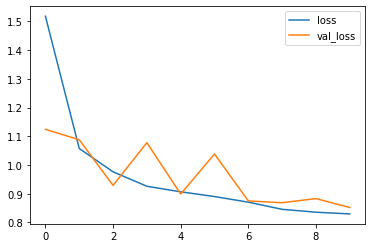

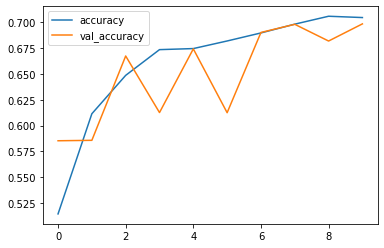

In [51]:
model_history = pd.DataFrame(history.history)
model_history[['loss', 'val_loss']].plot()
model_history[['accuracy', 'val_accuracy']].plot()

<div dir="rtl">
    <font size="3">قسمت دوم) تاثیر epoch<br>
    •اگر داده ها به اندازه کافی زیاد باشد لازم به استفاده از ایپاک نخواهد بود ولی از آنجایی که داده های ما محدود هستند ما فرایند آموزش را در چند ایپاک انجام میدهیم.<br>
    •افزایش بیش از اندازه تعداد ایپاکها موجب بروز overfitting میشود که برای جلوگیری ازین مشکل میتوان از راه حلهایی مانند early stopping، regularization، dropout و غیره استفاده کرد.</font>
</div>

In [52]:
input = layers.Input(shape=(100, 100, 1))
x = layers.Flatten()(input)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
output = layers.Dense(5, activation='softmax')(x)
model = models.Model(inputs=input, outputs=output)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, validation_data=test_data, epochs=20)

Epoch 1/20
519/519 [==============================] - 63s 121ms/step - loss: 1.4816 - accuracy: 0.5098 - val_loss: 1.2403 - val_accuracy: 0.5297
Epoch 2/20
519/519 [==============================] - 62s 119ms/step - loss: 1.0401 - accuracy: 0.6205 - val_loss: 0.9766 - val_accuracy: 0.6538
Epoch 3/20
519/519 [==============================] - 62s 120ms/step - loss: 0.9855 - accuracy: 0.6440 - val_loss: 0.9529 - val_accuracy: 0.6636
Epoch 4/20
519/519 [==============================] - 63s 121ms/step - loss: 0.9397 - accuracy: 0.6619 - val_loss: 0.9257 - val_accuracy: 0.6774
Epoch 5/20
519/519 [==============================] - 62s 119ms/step - loss: 0.9131 - accuracy: 0.6741 - val_loss: 0.8787 - val_accuracy: 0.6849
Epoch 6/20
519/519 [==============================] - 62s 120ms/step - loss: 0.8944 - accuracy: 0.6774 - val_loss: 0.9986 - val_accuracy: 0.6379
Epoch 7/20
519/519 [==============================] - 62s 119ms/step - loss: 0.8796 - accuracy: 0.6842 - val_loss: 0.8797 - val_ac

In [53]:
report(model, train_data, class_name, "train")
report(model, test_data, class_name, "test")

train:
              precision    recall  f1-score   support

       White       0.07      0.01      0.01      1165
       Black       0.16      0.29      0.21      2766
       Asian       0.16      0.07      0.10      2415
      Indian       0.19      0.12      0.15      3154
      Others       0.43      0.50      0.46      7094

    accuracy                           0.30     16594
   macro avg       0.20      0.20      0.19     16594
weighted avg       0.27      0.30      0.28     16594

test:
              precision    recall  f1-score   support

       White       0.23      0.01      0.02       525
       Black       0.45      0.84      0.59      1209
       Asian       0.87      0.39      0.54      1023
      Indian       0.87      0.57      0.68      1370
      Others       0.69      0.81      0.75      2984

    accuracy                           0.65      7111
   macro avg       0.62      0.52      0.52      7111
weighted avg       0.68      0.65      0.63      7111



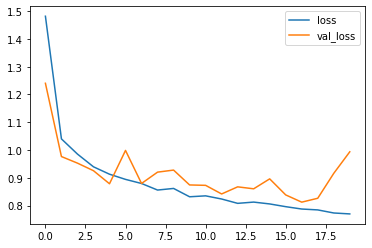

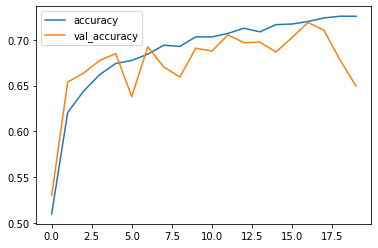

In [54]:
model_history = pd.DataFrame(history.history)
model_history[['loss', 'val_loss']].plot()
model_history[['accuracy', 'val_accuracy']].plot()

<div dir="rtl">
    <font size="3">قسمت سوم) تاثیر loss function<br>
    تابع mse برای مسائل regression مناسب است و خطا در مسائل classifiction بصورت صحیح یا غلط است.</font>
</div>

In [61]:
input = layers.Input(shape=(100, 100, 1))
x = layers.Flatten()(input)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
output = layers.Dense(5, activation='softmax')(x)
model = models.Model(inputs=input, outputs=output)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])
history = model.fit(train_data, validation_data=test_data, epochs=20)

Epoch 1/20
519/519 [==============================] - 64s 122ms/step - loss: 0.2289 - accuracy: 0.4267 - val_loss: 0.2321 - val_accuracy: 0.4196
Epoch 2/20
519/519 [==============================] - 62s 120ms/step - loss: 0.2290 - accuracy: 0.4275 - val_loss: 0.2321 - val_accuracy: 0.4196
Epoch 3/20
519/519 [==============================] - 62s 120ms/step - loss: 0.2290 - accuracy: 0.4275 - val_loss: 0.2321 - val_accuracy: 0.4196
Epoch 4/20
519/519 [==============================] - 63s 121ms/step - loss: 0.2290 - accuracy: 0.4275 - val_loss: 0.2321 - val_accuracy: 0.4196
Epoch 5/20
519/519 [==============================] - 62s 120ms/step - loss: 0.2290 - accuracy: 0.4275 - val_loss: 0.2321 - val_accuracy: 0.4196
Epoch 6/20
519/519 [==============================] - 63s 121ms/step - loss: 0.2290 - accuracy: 0.4275 - val_loss: 0.2321 - val_accuracy: 0.4196
Epoch 7/20
519/519 [==============================] - 63s 121ms/step - loss: 0.2290 - accuracy: 0.4275 - val_loss: 0.2321 - val_ac

In [57]:
report(model, train_data, class_name, "train")
report(model, test_data, class_name, "test")

train:
              precision    recall  f1-score   support

       White       0.00      0.00      0.00      1164
       Black       0.00      0.00      0.00      2774
       Asian       0.00      0.00      0.00      2410
      Indian       0.00      0.00      0.00      3161
      Others       0.43      1.00      0.60      7085

    accuracy                           0.43     16594
   macro avg       0.09      0.20      0.12     16594
weighted avg       0.18      0.43      0.26     16594



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test:
              precision    recall  f1-score   support

       White       0.00      0.00      0.00       525
       Black       0.00      0.00      0.00      1209
       Asian       0.00      0.00      0.00      1023
      Indian       0.00      0.00      0.00      1370
      Others       0.42      1.00      0.59      2984

    accuracy                           0.42      7111
   macro avg       0.08      0.20      0.12      7111
weighted avg       0.18      0.42      0.25      7111



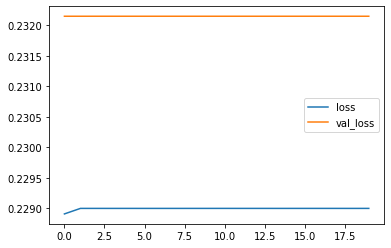

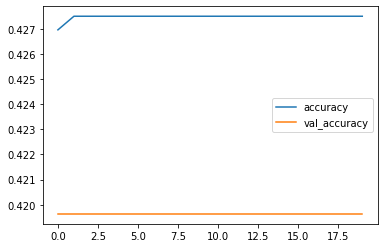

In [58]:
model_history = pd.DataFrame(history.history)
model_history[['loss', 'val_loss']].plot()
model_history[['accuracy', 'val_accuracy']].plot()

<div dir="rtl">
    <font size="3">قسمت چهارم) تاثیر regularization<br>
    regularization روشی برای کاهش پیچیدگی مدل است. استفاده از این روش باعث بهتر شدن نتیجه و افزایش accuracy شده است.</font>
</div>

In [64]:
input = layers.Input(shape=(100, 100, 1))
x = layers.Flatten()(input)
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.L2(0.0001))(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L2(0.0001))(x)
output = layers.Dense(5, activation='softmax')(x)
model = models.Model(inputs=input, outputs=output)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, validation_data=test_data, epochs=20)

Epoch 1/20
519/519 [==============================] - 91s 174ms/step - loss: 1.6435 - accuracy: 0.5239 - val_loss: 1.2327 - val_accuracy: 0.5926
Epoch 2/20
519/519 [==============================] - 89s 172ms/step - loss: 1.1431 - accuracy: 0.6198 - val_loss: 1.1249 - val_accuracy: 0.6227
Epoch 3/20
519/519 [==============================] - 89s 172ms/step - loss: 1.0639 - accuracy: 0.6444 - val_loss: 1.2149 - val_accuracy: 0.5615
Epoch 4/20
519/519 [==============================] - 90s 174ms/step - loss: 1.0292 - accuracy: 0.6498 - val_loss: 0.9986 - val_accuracy: 0.6591
Epoch 5/20
519/519 [==============================] - 88s 170ms/step - loss: 0.9733 - accuracy: 0.6711 - val_loss: 0.9665 - val_accuracy: 0.6732
Epoch 6/20
519/519 [==============================] - 87s 168ms/step - loss: 0.9642 - accuracy: 0.6713 - val_loss: 1.0167 - val_accuracy: 0.6579
Epoch 7/20
519/519 [==============================] - 93s 178ms/step - loss: 0.9205 - accuracy: 0.6830 - val_loss: 0.9433 - val_ac

In [65]:
report(model, train_data, class_name, "train")
report(model, test_data, class_name, "test")

train:
              precision    recall  f1-score   support

       White       0.08      0.01      0.01      1166
       Black       0.17      0.14      0.15      2766
       Asian       0.14      0.13      0.14      2410
      Indian       0.20      0.16      0.18      3155
      Others       0.42      0.56      0.48      7097

    accuracy                           0.31     16594
   macro avg       0.20      0.20      0.19     16594
weighted avg       0.27      0.31      0.29     16594

test:
              precision    recall  f1-score   support

       White       0.44      0.03      0.06       525
       Black       0.67      0.51      0.58      1209
       Asian       0.73      0.70      0.72      1023
      Indian       0.84      0.68      0.75      1370
      Others       0.65      0.89      0.75      2984

    accuracy                           0.69      7111
   macro avg       0.67      0.56      0.57      7111
weighted avg       0.69      0.69      0.67      7111



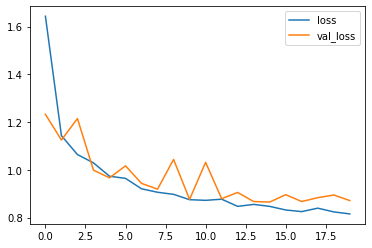

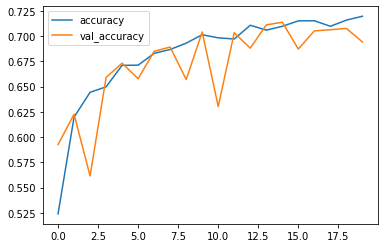

In [67]:
model_history = pd.DataFrame(history.history)
model_history[['loss', 'val_loss']].plot()
model_history[['accuracy', 'val_accuracy']].plot()

<div dir="rtl">
    <font size="3">با استفاده از dropout مشاهده میشود که شدت تغییرات loss و accuracy در داده های تست اندکی افزایش میابد و تغییرات این دو متغییر بیشتر میشود.</font>
</div>

In [11]:
input = layers.Input(shape=(100, 100, 1))
x = layers.Flatten()(input)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.1)(x)
output = layers.Dense(5, activation='softmax')(x)
model = models.Model(inputs=input, outputs=output)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, validation_data=test_data, epochs=20)

Epoch 1/20
519/519 [==============================] - 64s 122ms/step - loss: 1.5525 - accuracy: 0.4776 - val_loss: 1.2171 - val_accuracy: 0.5549
Epoch 2/20
519/519 [==============================] - 62s 120ms/step - loss: 1.1861 - accuracy: 0.5414 - val_loss: 1.0259 - val_accuracy: 0.6514
Epoch 3/20
519/519 [==============================] - 63s 121ms/step - loss: 1.0951 - accuracy: 0.5864 - val_loss: 1.1850 - val_accuracy: 0.4908
Epoch 4/20
519/519 [==============================] - 63s 121ms/step - loss: 1.0491 - accuracy: 0.6120 - val_loss: 1.0009 - val_accuracy: 0.6428
Epoch 5/20
519/519 [==============================] - 63s 121ms/step - loss: 1.0426 - accuracy: 0.6168 - val_loss: 0.9554 - val_accuracy: 0.6522
Epoch 6/20
519/519 [==============================] - 62s 120ms/step - loss: 1.0089 - accuracy: 0.6319 - val_loss: 0.9423 - val_accuracy: 0.6840
Epoch 7/20
519/519 [==============================] - 63s 121ms/step - loss: 1.0194 - accuracy: 0.6269 - val_loss: 0.9441 - val_ac

In [14]:
report(model, train_data, class_name, "train")
report(model, test_data, class_name, "test")

train:
              precision    recall  f1-score   support

       White       0.00      0.00      0.00      1167
       Black       0.73      0.40      0.52      2766
       Asian       0.95      0.35      0.52      2411
      Indian       0.78      0.76      0.77      3156
      Others       0.60      0.94      0.74      7094

    accuracy                           0.67     16594
   macro avg       0.61      0.49      0.51     16594
weighted avg       0.67      0.67      0.62     16594



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test:
              precision    recall  f1-score   support

       White       0.00      0.00      0.00       525
       Black       0.68      0.37      0.48      1209
       Asian       0.88      0.34      0.49      1023
      Indian       0.76      0.75      0.75      1370
      Others       0.59      0.93      0.72      2984

    accuracy                           0.65      7111
   macro avg       0.58      0.48      0.49      7111
weighted avg       0.64      0.65      0.60      7111



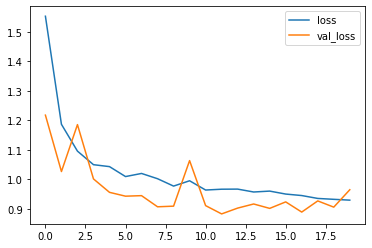

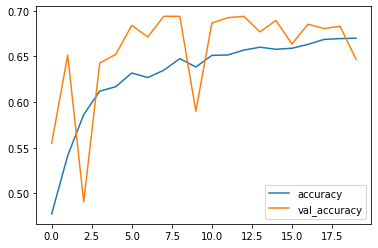

In [15]:
model_history = pd.DataFrame(history.history)
model_history[['loss', 'val_loss']].plot()
model_history[['accuracy', 'val_accuracy']].plot()

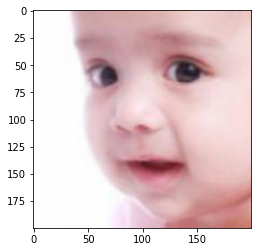

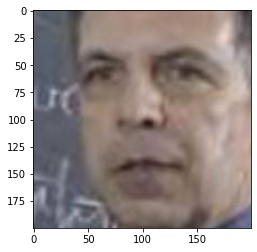

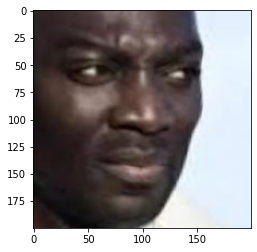

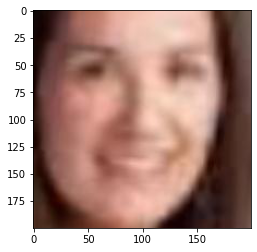

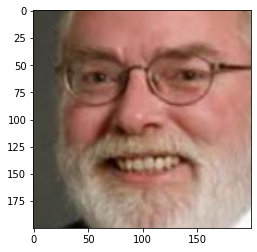

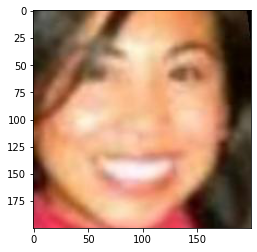

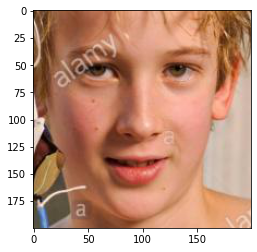

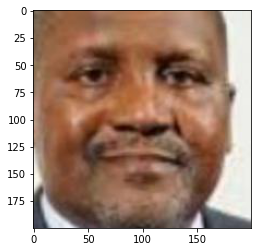

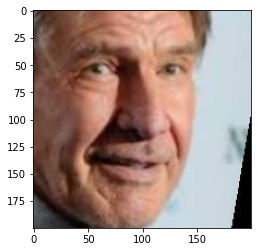

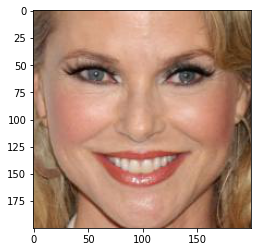

In [24]:
import matplotlib.image as mpimg

y_true = list()
batches = len(test_data.classes) // test_data.batch_size
if batches < len(test_data.classes) / test_data.batch_size:
  batches += 1
for i in range(batches):
  x, y = test_data.next()
  for label in y:
    y_true.append(np.argmax(label))
y_pred = list(np.argmax(model.predict(test_data), axis=1))
trues = 0
i = 0
while(trues < 10):
  if y_pred[i] == y_true[i]:
    trues += 1
    i += 1
    img = mpimg.imread(test_data.filepaths[i])
    imgplot = plt.imshow(img)
    plt.show()
  else:
    i += 1


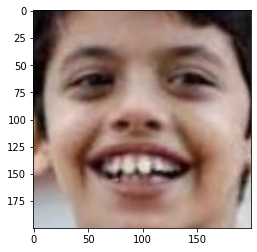

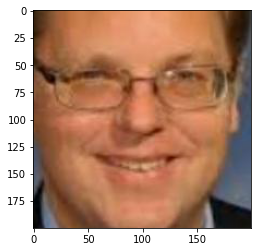

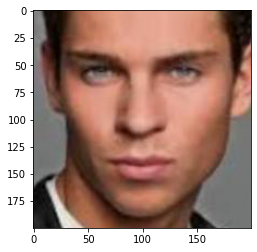

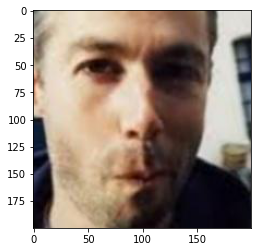

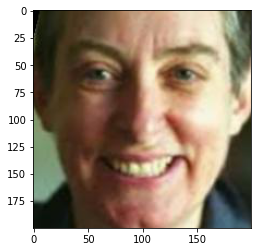

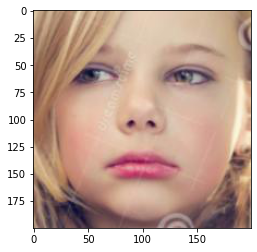

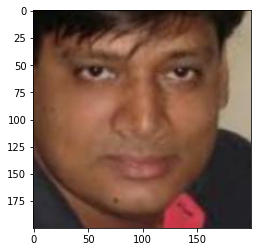

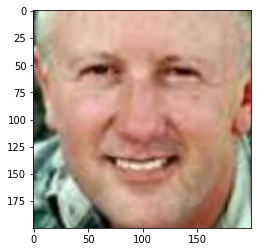

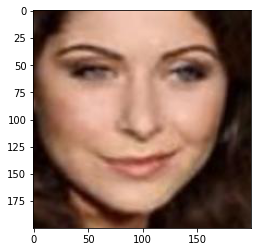

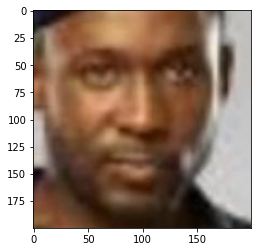

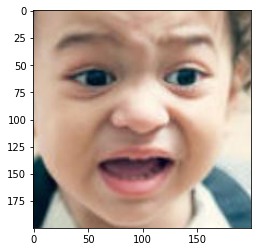

In [25]:
falses = 0
i = 0
while(falses < 11):
  if y_pred[i] != y_true[i]:
    falses += 1
    i += 1
    img = mpimg.imread(test_data.filepaths[i])
    imgplot = plt.imshow(img)
    plt.show()
  else:
    i += 1